In [2]:
"""
Created on Thu Sep 12 16:39:54 2024
@author: gmelis
"""

import math
import numpy as np
from decimal import Decimal
import scipy.stats as si

"""
Stores common attributes of a stock option
"""

class StockOption(object):
  def __init__(
    self, S0, K, r=0.05, T=1, N=2, pu=0.5, pd=0.5,
    div=0, sigma=0.3, is_put=False, is_am=False):

    """

    Initialize the stock option base class.
    Defaults to European call unless specified.

    :param S0: initial stock price
    :param K: strike price
    :param r: risk-free interest rate
    :param T: time to maturity
    :param N: number of time steps
    :param pu: probability at up state
    :param pd: probability at down state
    :param div: Dividend yield
    :param is_put: True for a put option,
    False for a call option
    :param is_am: True for an American option,
    False for a European option

    """
    self.S0 = S0
    self.K = K
    self.r = r
    self.T = T
    self.N = max(1, N)
    self.STs = [] # Declare the stock prices tree



    """ Optional parameters used by derived classes """
    self.pu, self.pd = pu, pd
    self.div = div
    self.sigma = sigma
    self.is_call = not is_put
    self.is_european = not is_am

  @property
  def dt(self):
    """ Single time step, in years """
    return self.T/float(self.N)

  @property
  def df(self):
    """ The discount factor """
    return math.exp(-(self.r-self.div)*self.dt)



class BlackScholesModel:
    def __init__(self, S, K, T, r, sigma):
      self.S = S # Underlying asset price
      self.K = K # Option strike price
      self.T = T # Time to expiration in years
      self.r = r # Risk-free interest rate
      self.sigma = sigma # Volatility of the underlying asset



    def d1(self):
      return (np.log(self.S / self.K) + (self.r + 0.5 * self.sigma**2) * self.T) / (
      self.sigma * np.sqrt(self.T))

    def d2(self):
      return self.d1() - self.sigma * np.sqrt(self.T)

    def call_option_price(self):
      return self.S * si.norm.cdf(self.d1(), 0.0, 1.0) - self.K * np.exp(
      -self.r * self.T) * si.norm.cdf(self.d2(), 0.0, 1.0)

    def put_option_price(self):
      return self.K * np.exp(-self.r * self.T) * si.norm.cdf(
      -self.d2(), 0.0, 1.0) - self.S * si.norm.cdf(-self.d1(), 0.0, 1.0)



"""

Price a European option by the binomial tree model

"""

class BinomialEuropeanOption(StockOption):
  def setup_parameters(self):
    # Required calculations for the model
    self.M = self.N+1 # Number of terminal nodes of tree
    self.u = 1+self.pu # Expected value in the up stat
    self.d = 1-self.pd # Expected value in the down state
    self.qu = (math.exp((self.r-self.div)*self.dt)-self.d)/(self.u-self.d)
    self.qd = 1-self.qu

  def init_stock_price_tree(self):
    # Initialize terminal price nodes to zeros
    self.STs = np.zeros(self.M)
    # Calculate expected stock prices for each node
    for i in range(self.M):
      self.STs[i] = self.S0 * (self.u**(self.N-i)) * (self.d**i)



  def init_payoffs_tree(self):
    """
    Returns the payoffs when the option
    expires at terminal nodes
    """
    if self.is_call:
      return np.maximum(0, self.STs-self.K)
    else:
      return np.maximum(0, self.K-self.STs)



  def traverse_tree(self, payoffs):
    """
    Starting from the time the option expires, traverse
    backwards and calculate discounted payoffs at each node
    """
    for i in range(self.N):
      payoffs = (payoffs[:-1]*self.qu +
      payoffs[1:]*self.qd)*self.df
    return payoffs



  def begin_tree_traversal(self):
    payoffs = self.init_payoffs_tree()
    return self.traverse_tree(payoffs)

  def price(self):
    """ Entry point of the pricing implementation """
    self.setup_parameters()
    self.init_stock_price_tree()
    payoffs = self.begin_tree_traversal()

    # Option value converges to first node
    return payoffs[0]


class Strategy:
  def __init__(self, option1, option2, option3):
    self.option1 = option1
    self.option2 = option2
    self.option3 = option3

  def bull_spread(self):
    bsm1 = BlackScholesModel(self.option1.S0,  self.option1.K,self.option1.T,self.option1.r, self.option1.sigma)
    bsm2 = BlackScholesModel(self.option2.S0,  self.option2.K,self.option2.T,self.option2.r, self.option1.sigma)
    if self.option1.is_call and self.option2.is_call:
      if self.option1.K < self.option2.K:
        return {"Portfolio" :[self.option1 , self.option2], "Value" : -bsm1.call_option_price()+bsm2.call_option_price() , "Nature" : "BullSpread","Strikes": [self.option1.K,self.option2.K]}
      else:
        print("Invalid combination for bull spread")
    elif self.option.is_call==False and self.option2.is_call==False :
      if self.option1.K < self.option2.K :
        return {"Portfolio" :[self.option1 , self.option2], "Value" : -bsm1.put_option_price()+bsm2.put_option_price() , "Nature" : "BullSpread", "Strikes": [self.option1.K,self.option2.K]}
      else :
        print('Invalid combination for bull spread')

  def bear_spread(self):
    bsm1 = BlackScholesModel(self.option1.S0,  self.option1.K,self.option1.T,self.option1.r, self.option1.sigma)
    bsm2 = BlackScholesModel(self.option2.S0,  self.option2.K,self.option2.T,self.option2.r, self.option1.sigma)
    if self.option1.is_call==False and self.option2.is_call==False:
      if self.option1.K < self.option2.K:
        return {"Portfolio":[self.option1,self.option2] , "Value": bsm1.put_option_price()-bsm2.put_option_price() , "Nature":"BearSpread","Strikes": [self.option1.K,self.option2.K]}
      else:
        print("Invalid combination for bear spread")
    elif self.option1.is_call and self.option2.is_call:
      if self.option1.K < self.option2.K :
        return {"Portfolio":[self.option1,self.option2] , "Value": bsm1.call_option_price()-bsm2.call_option_price() , "Nature":"BearSpread","Strikes": [self.option1.K,self.option2.K]}
      else :
        print("Invalid combination for bear spread")


  def butterfly(self):
    if self.option1.is_call and self.option2.is_call and self.option3.is_call:
      bsm1 = BlackScholesModel(self.option1.S0,  self.option1.K,self.option1.T,self.option1.r, self.option1.sigma)
      bsm2 = BlackScholesModel(self.option2.S0,  self.option2.K,self.option2.T,self.option2.r, self.option2.sigma)
      bsm3 =  BlackScholesModel(self.option3.S0,  self.option3.K,self.option3.T,self.option2.r, self.option3.sigma)
      if self.option1.K < self.option2.K and self.option2.K < self.option3.K:
        return {"Portfolio":[self.option1,self.option2, self.option2, self.option3],"Value" : 2*bsm2.call_option_price()-bsm1.call_option_price()-bsm3.call_option_price(), "Nature":"Butterfly","Strikes": [self.option1.K,self.option2.K,self.option3.K]}
      else:
        print("Invalid combination for butterfly")
    else:
      print("Invalid combination for butterfly")





opt1 = StockOption(80,85)
opt2 = StockOption(80, 95)
opt3 = StockOption(80, 105)



strat = Strategy(opt1,opt2,opt3)

butterfly = strat.butterfly()
bear = strat.bear_spread()
bull = strat.bull_spread()



opt4 = StockOption(80, 85)
price = BlackScholesModel(80,85, 1, 0.05, 0.3).call_option_price()

In [3]:
pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 2.9 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
from hmmlearn import hmm

In [28]:
data = yf.download("^GSPC")
returns = np.log(data.Close / data.Close.shift(1))
range = (data.High - data.Low)
features = pd.concat([returns, range], axis=1).dropna()
features.columns = ["returns", "range"]

print(features.head())

[*********************100%***********************]  1 of 1 completed

             returns  range
Date                       
1928-01-03  0.005647    0.0
1928-01-04 -0.002255    0.0
1928-01-05 -0.009640    0.0
1928-01-06  0.006248    0.0
1928-01-09 -0.009101    0.0


In [29]:
model = hmm.GaussianHMM(
    n_components=3,
    covariance_type="diag",
    n_iter=1000,
)
model.fit(features)

GaussianHMM(n_components=3, n_iter=1000)

<Axes: >

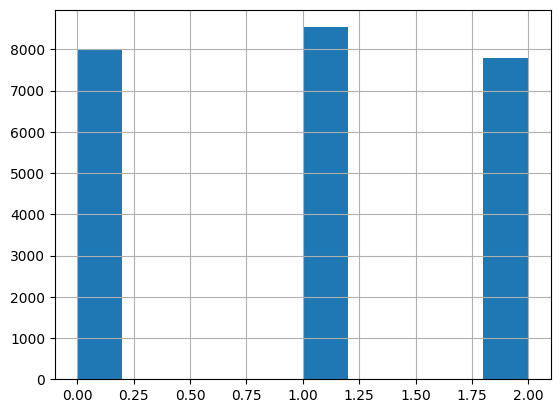

In [30]:
states = pd.Series(model.predict(features), index=data.index[1:])
states.name = "state"
states.hist()

<Axes: xlabel='Date'>

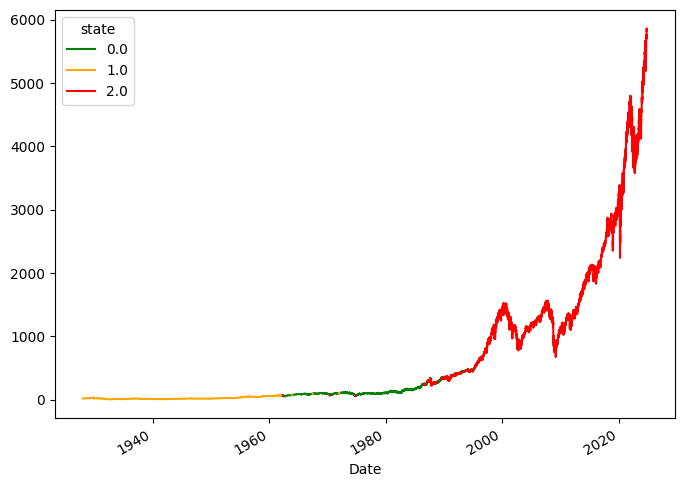

In [31]:
color_map = {
    0.0: "green",
    1.0: "orange",
    2.0: "red"
}
(
    pd.concat([data.Close, states], axis=1)
    .dropna()
    .set_index("state", append=True)
    .Close
    .unstack("state")
    .plot(color=color_map, figsize=[8, 6])
)

In [12]:
from datetime import datetime

def increment_month(date_input):
    """
    Incrémente le mois d'une date. Si le mois est 12, passe à l'année suivante.

    Args:
        date_input (datetime): La date à modifier.

    Returns:
        datetime: La nouvelle date avec le mois (ou l'année) modifié.
    """
    year = date_input.year
    month = date_input.month

    if month < 12:
        new_month = month + 1
        new_date = datetime(year, new_month, date_input.day)
    else:
        new_year = year + 1
        new_date = datetime(new_year, 1, date_input.day)

    return new_date

# Exemple d'utilisation
date = datetime(1999, 12, 15)
new_date = increment_month(date)
print("Nouvelle date :", new_date)

def decrement_month(date_input):
    """
    Incrémente le mois d'une date. Si le mois est 12, passe à l'année suivante.

    Args:
        date_input (datetime): La date à modifier.

    Returns:
        datetime: La nouvelle date avec le mois (ou l'année) modifié.
    """
    year = date_input.year
    month = date_input.month

    if month > 1:
        new_month = month - 1
        new_date = datetime(year, new_month, date_input.day)
    else:
        new_year = year - 1
        new_date = datetime(new_year, 12, date_input.day)

    return new_date

Nouvelle date : 2000-01-15 00:00:00


In [13]:
def calculate_historical_volatility(stock_data, window=252):
    log_returns = np.log(stock_data['Close'] / stock_data['Close'].shift(1))
    volatility = np.sqrt(window) * log_returns.std()
    return volatility

jpm_volatility = calculate_historical_volatility(data)
print(f"Historical Volatility: {jpm_volatility}")

Historical Volatility: 0.18986510561225725


In [34]:
def strategy(start_date,end_date=datetime.today()):
  date = start_date
  portfolio = []
  gains = 0
  Index = 1000
  Index_value = []
  dates = []
  Gains =[]

  while date < end_date :

    date2 = increment_month(date)
    date3 = increment_month(date2)
    date_m1 = decrement_month(date)
    date_m2 = decrement_month(date_m1)
    data = yf.download("^GSPC",start=date_m2, end=date)

    dates+=[date]

    returns = np.log(data.Close / data.Close.shift(1))
    range = (data.High - data.Low)
    features = pd.concat([returns, range], axis=1).dropna()
    features.columns = ["returns", "range"]

    model = hmm.GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000)
    model.fit(features)

    states = pd.Series(model.predict(features), index=data.index[1:])
    states.name = "state"

    result = states.mode()[0]
    T = 22/252
    r = 0.05
    sigma = jpm_volatility
    spot = list(data.Close)[0]

    #vérification de la condition de vente

    for val in portfolio :
      gains -= val['Value']
      if val["Nature"] == "BullSpread" :
        if val["Strikes"][1] < spot :
          print('Exercice !')
          gains +=  val["Strikes"][1] - val["Strikes"][0]
          Index += val["Strikes"][1] - val["Strikes"][0]
        elif val["Strikes"][0] < spot < val["Strikes"][1] :
          print("Exercice !")
          gains+= val["Strikes"][0] - spot
          Index+= val["Strikes"][0] - spot
        else :
          pass

      elif val['Nature'] == "BearSpread" :
        if val["Strikes"][1] < spot :
          pass
        elif val["Strikes"][0] < spot < val["Strikes"][1] :
          print("Exercice !")
          gains +=  val["Strikes"][1] - spot
          Index += val["Strikes"][1] - spot
        elif spot < val["Strikes"][0]:
          print('Exercice !')
          gains +=  val["Strikes"][1] - val["Strikes"][0]
          Index+= val["Strikes"][1] - val["Strikes"][0]

      elif val['Nature']=='Butterfly' :
        if spot <= val['Strikes'][0] :
          pass
        elif val['Strikes'][0] < spot < val['Strikes'][1] :
          gains+= spot - val['Strikes'][0]
          Index+= spot - val['Strikes'][0]
        elif val['Strikes'][1] < spot < val['Strikes'][2] :
          gains+=  val['Strikes'][2] - spot
          Index+= val['Strikes'][2] - spot
        else :
          pass

      portfolio.pop(portfolio.index(val))


    if result == 2 : #bear market
      K1 = spot
      K2 = 1.20 *spot
      option1 = StockOption(spot,K1,r,T)
      option2 = StockOption(spot,K2,r,T)

      bear = Strategy(option1,option2,option2).bear_spread() #On peut potentiellement en acheter 10, 100 ,etc...

      portfolio+=[bear]

    elif result ==1 : #flat
      K1 = 1.05*spot
      K2 = 1.10*spot
      K3 = 1.20*spot

      option1 = StockOption(spot,K1,r,T)
      option2 = StockOption(spot,K2,r,T)
      option3 = StockOption(spot,K3,r,T)

      butterfly = Strategy(option1,option2,option3).butterfly()

      portfolio+=[butterfly]

    elif result == 0 : #Bull market
      K1 = 1.10*spot
      K2 = 1.20*spot

      option1 = StockOption(spot,K1,r,T)
      option2 = StockOption(spot,K2,r,T)

      bull = Strategy(option1,option2,option2).bull_spread()

      portfolio+=[bull]

    Index_value+=[Index]
    Gains+=[gains]

    date = date2
    #print(portfolio)

  print("Gains réalisés : ", gains)
  return [dates, Index_value,Gains]

results = strategy(datetime(2019, 1, 1))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Exercice !
Exercice !


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Exercice !
Exercice !
Exercice !



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Exercice !
Exercice !



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Exercice !



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Exercice !
Exercice !



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Exercice !
Exercice !


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Exercice !



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Exercice !
Exercice !


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Exercice !



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Exercice !



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Exercice !


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Exercice !


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Exercice !



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Exercice !
Exercice !



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Exercice !
Gains réalisés :  12460.140017049105


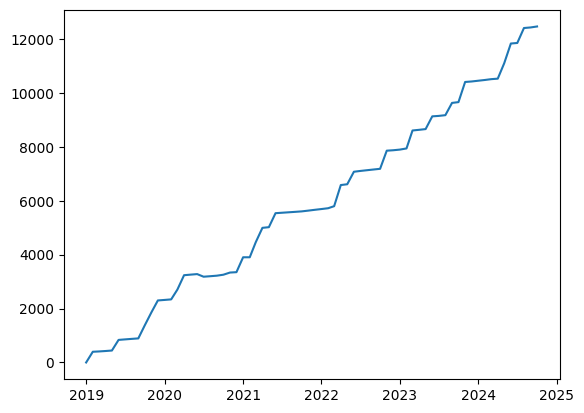

In [35]:
import matplotlib.pyplot as plt

#plt.plot(results[0],results[1])
plt.plot(results[0],results[2])
plt.show()

[*********************100%***********************]  1 of 1 completed


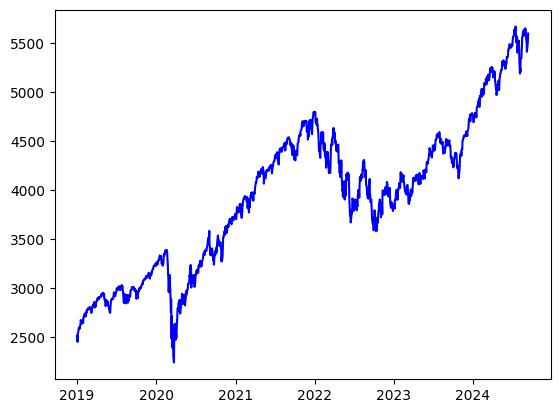

In [41]:
stock = yf.download('^GSPC', start='2019-01-01', end='2024-09-13')
plt.plot(stock['Close'], label='S&P500', color='blue')
plt.show()